I am trying to fully understand how to do Weinder deconvolution using Python. I am also curious about its performance under different amounts of noise. 

In [1]:
# import numpy for handling arrays
import numpy as np
# matplotlib for plotting
from matplotlib import pyplot as plt
import seaborn as sbn
# scipy.signal for the deconvolution function
from scipy import signal, stats
# holocube.tools for the m-sequence
import tools
%matplotlib widget

In [2]:
num_seqs = 43
# generate m-sequences with a powerval of 9
mseqs = np.array([tools.mseq(2, 9, seq) for seq in range(num_seqs)])
# let's convolve the signals with a 
system = ([1.0], [1.0, 2.0, 1.0])
t, impulse = signal.impulse(system, T=np.arange(10))
signals = np.array([signal.convolve(mseq, impulse, mode='valid') for mseq in mseqs])
# choose 10 logarithmically spaced signal-to-noise ratios
# between 0.1 and 10
snrs = np.logspace(-4, 4, 9, base=2)
# we're going to combine the signals, scaled by the snr, and add noise
# to the resulting signals

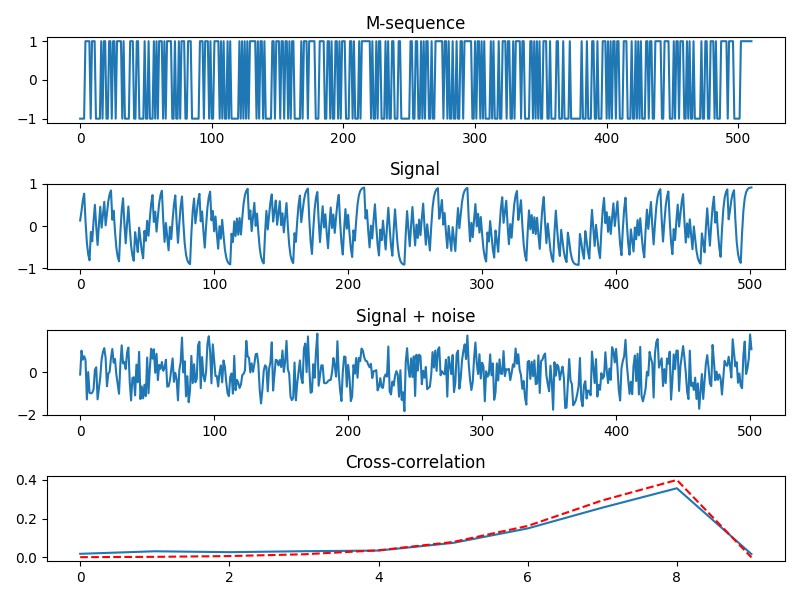

In [3]:
SNR = 1
# plot one example mseq, signal, and their cross-correlation
plt.figure(figsize=(8, 6))
# plot the original m-sequence
plt.subplot(4, 1, 1)
plt.plot(mseqs[0])
plt.title('M-sequence')
# the convolved signal
plt.subplot(4, 1, 2)
plt.plot(signals[0])
plt.title('Signal')
# the convolved signal + uniform noise
plt.subplot(4, 1, 3)
signal_noise = SNR*signals[0] + np.random.uniform(-1, 1, signals[0].shape)
plt.plot(signal_noise)
plt.title('Signal + noise')
# and the cross-correlation with the noisy signal
plt.subplot(4, 1, 4)
corr = signal.correlate(mseqs[0], signal_noise, mode='valid')
corr /= corr.sum()
plt.plot(corr)
# and the original kernal for comparison
plt.plot(impulse[::-1]/impulse.sum(), 'r--')
plt.title('Cross-correlation')
plt.tight_layout()

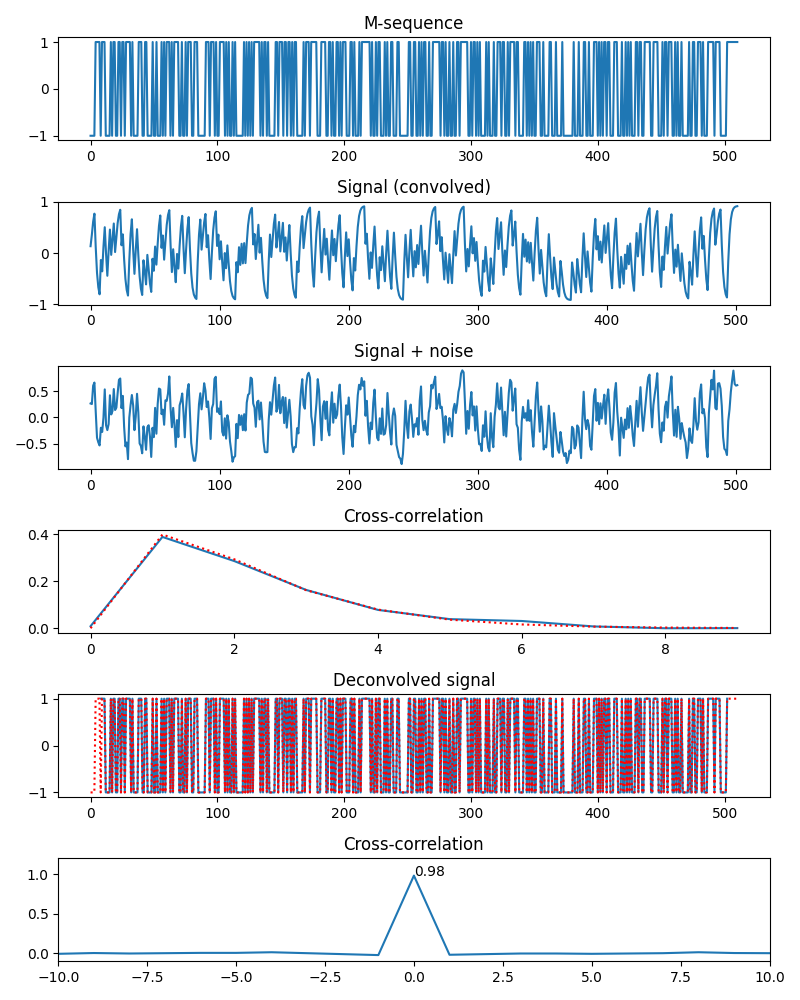

In [4]:
SNR = 5
# plot one example mseq, signal, and their cross-correlation
plt.figure(figsize=(8, 10))
# plot the original m-sequence
plt.subplot(6, 1, 1)
plt.plot(mseqs[0])
plt.title('M-sequence')
# the convolved signal
plt.subplot(6, 1, 2)
plt.plot(signals[0])
plt.title('Signal (convolved)')
# the convolved signal + uniform noise
plt.subplot(6, 1, 3)
signal_noise = (SNR * signals[0] + np.random.uniform(-1, 1, signals[0].shape)) / (SNR + 1)
plt.plot(signal_noise)
plt.title('Signal + noise')
# and the cross-correlation with the noisy signal
plt.subplot(6, 1, 4)
# corr = signal.correlate(mseqs[0], signals[0], mode='valid')
corr = signal.correlate(mseqs[0], signal_noise, mode='valid')
corr /= corr.sum()
# we need to make the correlation non-negative
new_corr = np.zeros(corr.shape)
new_corr[corr > 0] = corr[corr > 0]
plt.plot(new_corr[::-1])
# and the original kernel for comparison
plt.plot(impulse / impulse.sum(), 'r:')
plt.title('Cross-correlation')
# now, let's use the deconvolution function to recover the original signal
plt.subplot(6, 1, 5)
# recovered = signal.deconvolve(signal_noise, impulse[impulse > 0])
# recovered = signal.deconvolve(signal_noise, new_corr[1:][::-1])
recovered = signal.deconvolve(signal_noise, corr[1:-1][::-1])
# due to the convolution earlier, the signal is misaligned with the deconvolved signal
# so we need to shift it back
offset = 8
xs = np.arange(offset, offset + len(recovered[0]))
# binarize the recovered signal to be -1 when < 0, 1 otherwise
recovered = np.sign(recovered[0])
recovered[recovered < 0] = -1
recovered[recovered >= 0] = 1
# recovered = recovered[0]
plt.plot(xs, recovered)
plt.plot(mseqs[0], 'r:')
plt.ylim(-1.1, 1.1)
plt.title('Deconvolved signal')
# plot the cross-correlation with mode='valid'
plt.subplot(6, 1, 6)
corr_valid = signal.correlate(mseqs[0], recovered, mode='same')
# normalize the cross-correlation to give pearson's correlation coefficient
corr_valid /= np.sqrt(np.sum(mseqs[0]**2) * np.sum(recovered**2))
# get the appropriate lag values
lags = np.arange(-len(mseqs[0]) + 1, len(mseqs[0]))
lags = lags[len(lags) // 2:]
lags -= lags.max() // 2
plt.plot(lags, corr_valid)
# annotate the maximum correlation
max_x = np.argmax(corr_valid)
max_corr = corr_valid[max_x]
plt.annotate(f'{max_corr:.2f}', (lags[max_x], corr_valid[max_x]))
plt.ylim(-.1, 1.2)
plt.xlim(-10, 10)
plt.title('Cross-correlation')
plt.tight_layout()


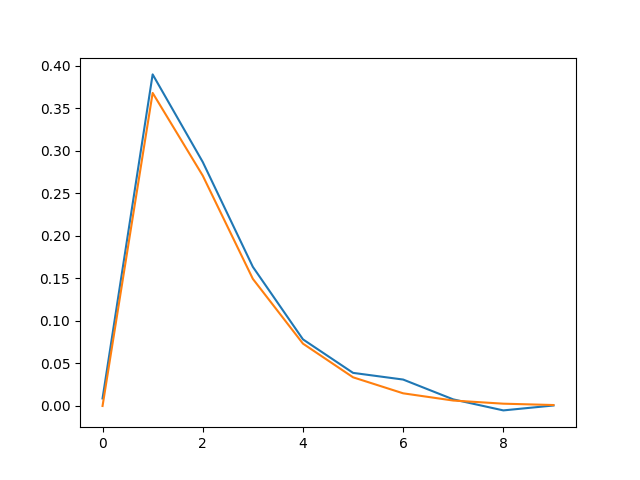

In [5]:
plt.figure()
plt.plot(corr[::-1])
plt.plot(impulse)

In [6]:
signals_scaled = snrs[:, None, None] * signals[None, :, :]
signals_noisy = (signals_scaled + np.random.uniform(-1, 1, signals_scaled.shape))/(1+snrs[:, None, None])
# signals_noisy = signals_scaled
# let's calculate the cross-correlations between the m-sequence and the noisy signals
cross_corrs = []
for mseq, noisy_signals in zip(mseqs, signals_noisy.transpose(1, 0, 2)):
    corrs = np.array([signal.correlate(mseq, noisy_signal, mode='valid') for noisy_signal in noisy_signals])
    # corrs /= corrs.sum(axis=1)[:, None]
    cross_corrs.append(corrs)
cross_corrs = np.array(cross_corrs)
cross_corrs = cross_corrs.transpose(1, 0, 2)
# and let's get the normalized cross-correlations
cross_corrs_norm = cross_corrs / cross_corrs.sum(axis=2)[:, :, None]

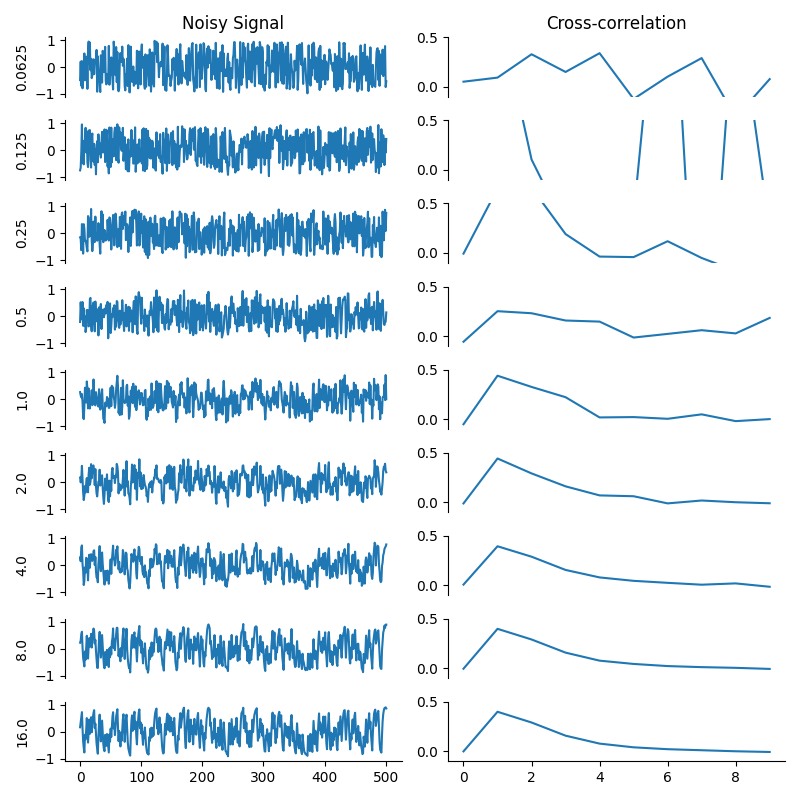

In [7]:
# plot the same m-sequence with all of the SNRs
arr = signals_noisy[:, 0]
# plot all 9 signals
fig, axes = plt.subplots(len(snrs), 2, figsize=(8, 8), sharex=False, sharey=False)
axes[0, 0].set_title('Noisy Signal')
axes[0, 1].set_title('Cross-correlation')
mseq = mseqs[0]
for i, (vals, corr, row) in enumerate(zip(arr, cross_corrs_norm[:, 0], axes)):
    ax = row[0]
    ax.plot(vals, label=f'SNR={snrs[i]:.2f}')
    # ax.plot(mseq, 'r:', alpha=.1)
    ax.set_ylabel(snrs[i])
    ax.set_ylim(-1.1, 1.1)
    ax = row[1]
    ax.plot(corr[::-1])
    ax.set_ylim(-.1, .5)
    for ax in row:
        if i != len(snrs) - 1:
            sbn.despine(ax=ax, bottom=True)
            ax.set_xticks([])
        else:
            sbn.despine(ax=ax)
    
plt.tight_layout()

In [8]:
# now, let's use the cross-correlations to deconvolve the noisy signals
deconvolved = []
for cross_corr_vals, noisy_signals in zip(cross_corrs_norm, signals_noisy):
    deconvolved_sub = []
    for cross_corr, noisy_signal in zip(cross_corr_vals, noisy_signals):
        recovered = signal.deconvolve(noisy_signal, cross_corr[1:-1][::-1])
        # use the sign function to binarize the signal
        recovered = np.sign(recovered[0])
        recovered[recovered < 0] = -1
        recovered[recovered >= 0] = 1
        # store
        deconvolved_sub.append(recovered)
    deconvolved.append(deconvolved_sub)
deconvolved = np.array(deconvolved)

In [9]:
deconvolved.shape

(9, 43, 495)

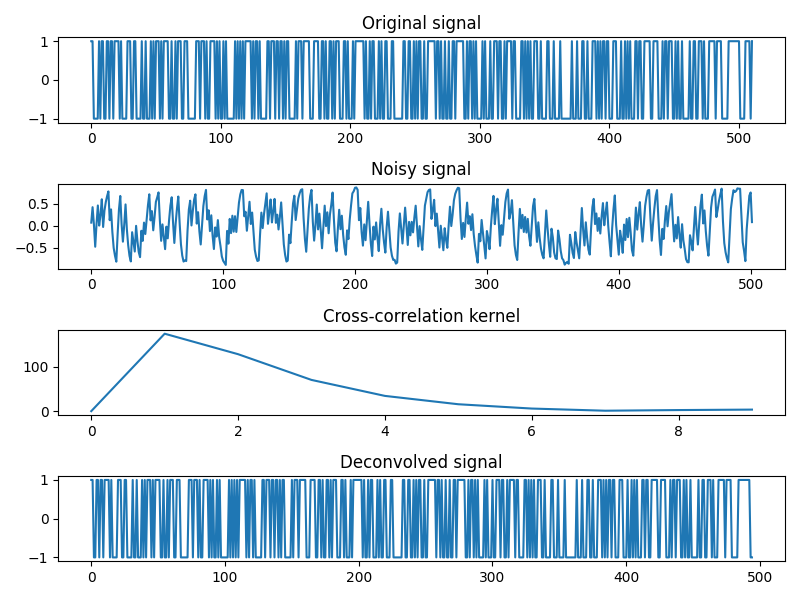

In [10]:
mseq_ind = 10
snr_ind = -1

original_signal = mseqs[mseq_ind]
noisy_signal = signals_noisy[snr_ind, mseq_ind]
cross_corr = cross_corrs[snr_ind, mseq_ind]
# use only the positive part of the cross-correlation
# cross_corr = cross_corr[cross_corr > 0]
# deconvolve the noisy signal
# deconvolved_signal = signal.deconvolve(noisy_signal, cross_corr[::-1])
deconvolved_signal = deconvolved[snr_ind, mseq_ind]
# plot all 3 in separate subplots
plt.figure(figsize=(8, 6))
# original signal
plt.subplot(4, 1, 1)
plt.plot(original_signal)
plt.title('Original signal')
# noisy signal
plt.subplot(4, 1, 2)
plt.plot(noisy_signal)
plt.title('Noisy signal')
# cross-correlation kernel
plt.subplot(4, 1, 3)
plt.plot(cross_corr[::-1])
plt.title('Cross-correlation kernel')
# deconvolved signal
plt.subplot(4, 1, 4)
plt.plot(deconvolved_signal)
# plt.ylim(-10, 10)
# plt.semilogy()
plt.title('Deconvolved signal')
plt.tight_layout()

In [11]:
# calculate the 0 lag correlation between the original m-sequence and the deconvolved signals
pearson_corrs = []
for mseq, deconvolved_signals in zip(mseqs, deconvolved.transpose(1, 0, 2)):
    corrs = []
    for deconvolved_signal in deconvolved_signals:
        corr = signal.correlate(mseq, deconvolved_signal, mode='valid')
        # normalize the correlation
        corr /= np.sqrt(np.sum(mseq**2) * np.sum(deconvolved_signal**2))
        corrs += [corr[8]]
    pearson_corrs.append(corrs)
pearson_corrs = np.array(pearson_corrs)

In [12]:
# make a pandas dataframe to store the results
# each column should be a different SNR
# and each row should be a different m-sequence
import pandas as pd
df = pd.DataFrame(pearson_corrs, columns=snrs)

Text(50.722222222222214, 0.5, 'M-sequence')

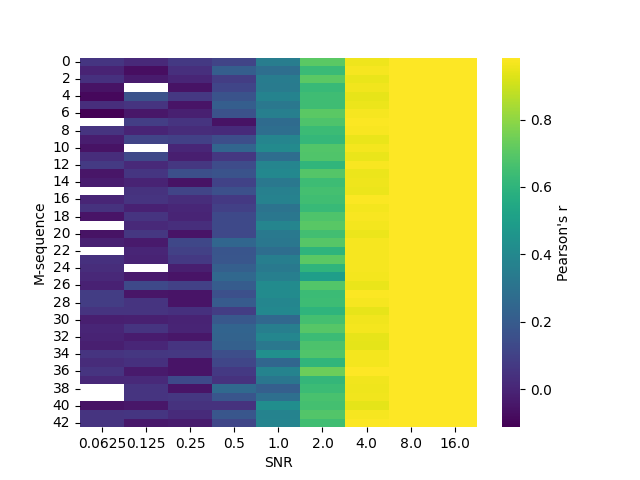

In [13]:
# plot the data frame as a heatmap
plt.figure()
# 
sbn.heatmap(df, annot=False, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Pearson\'s r'})
plt.xlabel('SNR')
plt.ylabel('M-sequence')

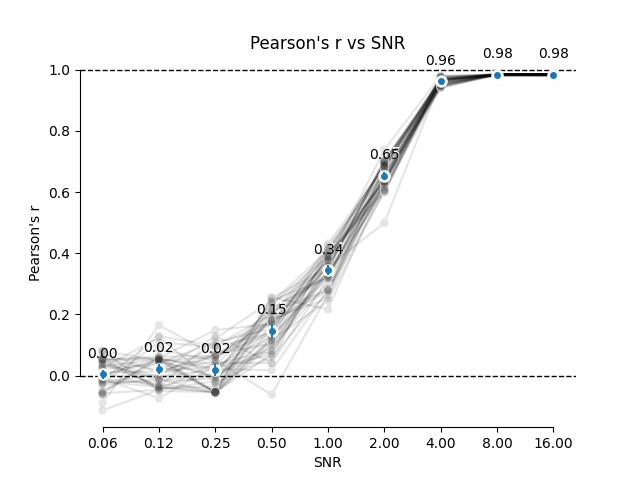

In [14]:
# and as a scatter plot with a log x-axis, separate points per m-sequence, and 95% confidence intervals of the mean for each SNR
plt.figure()
# calculate the means and confidence intervals
means = df.mean()
stds = df.std()
n = df.shape[0]
conf_int = stats.t.ppf(1 - 0.025, n - 1) * stds / np.sqrt(n)
# plot a line for each m-sequence
for i, row in df.iterrows():
    plt.plot(snrs, row, '-', alpha=.1, color='k')
    plt.scatter(snrs, row, alpha=1, color='w', edgecolors='none', zorder=3)
    plt.scatter(snrs, row, alpha=.1, color='k', edgecolors='none', zorder=4)
plt.errorbar(snrs, means, yerr=conf_int, fmt='o', color='w', markersize=8, zorder=5)
plt.errorbar(snrs, means, yerr=conf_int, fmt='o', markersize=4, zorder=6)
# annotate each point with the mean y-value next to it
for snr, mean in zip(snrs, means):
    plt.annotate(f'{mean:.2f}', (snr, mean), textcoords='offset points', xytext=(0, 10), ha='center', va='bottom', size=10.5, color='w')
    plt.annotate(f'{mean:.2f}', (snr, mean), textcoords='offset points', xytext=(0, 10), ha='center', va='bottom', size=10, color='k')

plt.xscale('log', base=2)
plt.axhline(0, color='k', lw=1, linestyle='--')
plt.axhline(1, color='k', lw=1, linestyle='--')
sbn.despine(ax=plt.gca(), trim=True)
# use easy to read x-tick labels
plt.xticks(snrs, [f'{snr:.2f}' for snr in snrs])
plt.xlabel('SNR')
plt.ylabel('Pearson\'s r')
plt.title('Pearson\'s r vs SNR')
plt.show()